In [1]:
%matplotlib inline

import scipy.io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import collections
import glob
import itertools

In [2]:
def weights(N, seed=0):
    random = np.random.RandomState(seed)
    W = random.rand(N, N)
    W = (W + W.T) / 2  # symmetrically
    W *= (1 - np.eye(N))  # zero diagonal
    return W

In [3]:
class Annealing:

    def __init__(self, weight, beta, tau, t_max, m=1, seed=0):
        self.w = weight
        self.beta = beta
        self.tau = tau
        self.t_max = t_max
        self.m = m
        self.random = np.random.RandomState(seed)

    def __call__(self):
        n = self.w.shape[0]
        s = np.array([-1, 1])[self.random.randint(0, 2, n)]
        costs = [self.energy(s)]
        for t in range(self.t_max):
            for _ in range(self.m):
                s = self.update_state(s)
            costs.append(self.energy(s))
            self.beta *= self.tau
        return s, costs
        
    def energy(self, s):
        return -0.5 * (np.outer(s, s) * self.w).sum()

    def update_state(self, s):
        raise NotImplementedError

M=500 Result -8.34157189151
M=1 Result -8.34157189151


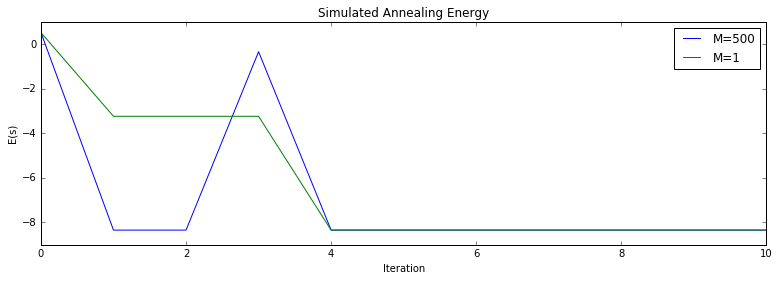

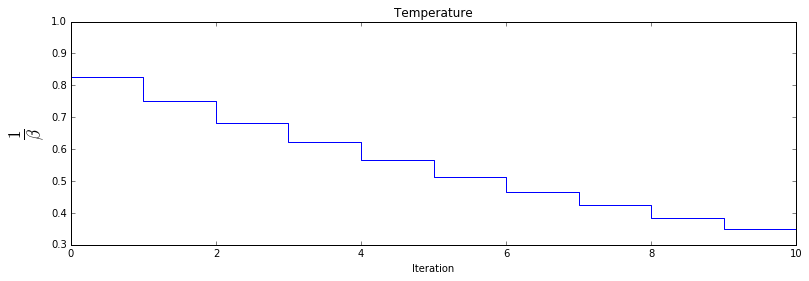

In [4]:
class SimulatedAnnealing(Annealing):
    
    def update_state(self, s):
        i = self.random.randint(0, s.shape[0])
        candidate = s.copy()
        candidate[i] *= -1
        difference = -2 * self.local_energy(s, i)
        probability = 1 / (1 + np.e ** (self.beta * difference))
        return [s, candidate][self.random.rand() < probability]

    def local_energy(self, s, i):
        return -0.5 * (s[i] * s * self.w[i]).sum()

fig, ax = plt.subplots(figsize=(13, 4))
ax.set_title('Simulated Annealing Energy')
ax.set_xlabel('Iteration')
ax.set_ylabel('E(s)')

t_max, beta, tau = 10, 1.1, 1.1
for m in (500, 1):
    _, costs = SimulatedAnnealing(weights(6), beta, tau, t_max, m=m)()
    print('M={} Result'.format(m), costs[-1])
    ax.plot(np.linspace(0, t_max, len(costs)), costs, label='M={}'.format(m))

ax.legend()
plt.show()

fig, ax = plt.subplots(figsize=(13, 4))
ax.set_title('Temperature')
ax.set_xlabel('Iteration')
ax.set_ylabel(r'$\frac{1}{\beta}$', fontsize=24)
betas = [beta]
for _ in range(t_max):
    betas.append(tau * betas[-1])
temps = [1 / x for x in betas]
ax.step(np.arange(len(temps)), temps)
plt.show()

M=500 Result -8.34142161531
M=1 Result -8.34142160963


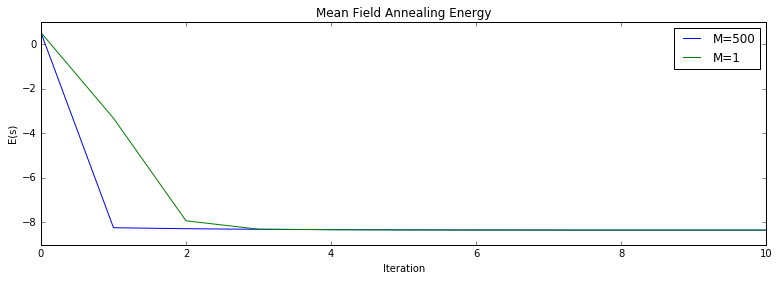

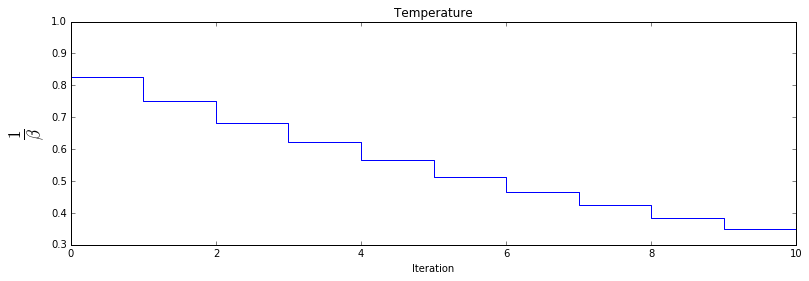

In [5]:
class MeanFieldAnnealing(Annealing):

    def update_state(self, s):
        fields = -np.dot(s, self.w)
        s = np.tanh(-self.beta * fields)
        return s

fig, ax = plt.subplots(figsize=(13, 4))
ax.set_title('Mean Field Annealing Energy')
ax.set_xlabel('Iteration')
ax.set_ylabel('E(s)')

t_max, beta, tau = 10, 1.1, 1.1
for m in (500, 1):
    _, costs = MeanFieldAnnealing(weights(6), beta, tau, t_max, m=m)()
    print('M={} Result'.format(m), costs[-1])
    ax.plot(np.linspace(0, t_max, len(costs)), costs, label='M={}'.format(m))

ax.legend()
plt.show()

fig, ax = plt.subplots(figsize=(13, 4))
ax.set_title('Temperature')
ax.set_xlabel('Iteration')
ax.set_ylabel(r'$\frac{1}{\beta}$', fontsize=24)
betas = [beta]
for _ in range(t_max):
    betas.append(tau * betas[-1])
temps = [1 / x for x in betas]
ax.step(np.arange(len(temps)), temps)
plt.show()